<a href="https://colab.research.google.com/github/afifrahmann/KALBE-Nutrisionals-Project/blob/master/KALBE_Nutrisionals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from itertools import permutations
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.23.5
pandas version :  1.5.3
seaborn version :  0.12.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Bootcamp Data Science Rakamin/flight.csv"
df_customer = pd.read_excel("/content/drive/MyDrive/Rakamin/PBI/customer.xlsx")
df_product = pd.read_excel("/content/drive/MyDrive/Rakamin/PBI/product.xlsx")
df_store = pd.read_excel("/content/drive/MyDrive/Rakamin/PBI/store.xlsx")
df_transaction = pd.read_excel("/content/drive/MyDrive/Rakamin/PBI/transaction.xlsx")

In [ ]:
df_customer.sample(5)

,CustomerID,Age,Gender,Marital Status,Income
368,369,32,0,Married,"10,62"
34,35,48,1,Married,"10,58"
63,64,48,1,Married,"7,92"
67,68,48,1,Married,"17,42"
116,117,45,1,Married,"12,55"


In [ ]:
df_product.sample(5)

,ProductID,Product Name,Price
3,P4,Potato Chip,12000
1,P2,Ginger Candy,3200
0,P1,Choco Bar,8800
2,P3,Crackers,7500
9,P10,Cheese Stick,15000


In [ ]:
df_store.sample(5)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
11,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
5,6,Lingga,Lingga,Modern Trade,-5.135399,119.423790
6,7,Buana Indah,Buana,General Trade,3.316694,114.590111
12,13,Buana,Buana,General Trade,-1.269160,116.825264
7,8,Sinar Harapan,Harapan Baru,General Trade,5.548290,95.323753


In [ ]:
df_transaction.sample(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
3843,TR59640,447,2022-10-04,P10,15000,1,15000,14
866,TR11956,83,2022-03-03,P5,4200,3,12600,6
1377,TR5922,241,2022-04-07,P2,3200,6,19200,11
3931,TR74570,415,2022-10-11,P4,12000,1,12000,6
358,TR38496,171,2022-01-26,P1,8800,7,61600,3


In [ ]:
# convert Date to datetime
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format='%d/%m/%Y')

In [ ]:
# fill missing values
df_customer.isna().sum()
df_customer.fillna(method='ffill', inplace=True)

In [ ]:
#Merge data
df_merge = pd.merge(df_transaction, df_product, on='ProductID', how='left')
df_merge = pd.merge(df_merge, df_store, on='StoreID', how='left')
df_merge = pd.merge(df_merge, df_customer, on='CustomerID', how='left')
df_merge.head(5)

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,7500,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,36,0,Married,"10,53"
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,Yoghurt,10000,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,44,1,Married,"14,58"
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,-6.966667,110.416664,27,1,Single,"0,18"
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,-6.966667,110.416664,48,1,Married,"12,57"
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,Yoghurt,10000,Gita Ginara,Gita,General Trade,-6.966667,110.416664,33,0,Married,"6,95"


In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   Price_y         5020 non-null   int64         
 10  StoreName       5020 non-null   object        
 11  GroupStore      5020 non-null   object        
 12  Type            5020 non-null   object        
 13  Latitude        5020 non-null   float64       
 14  Longitude       5020 non-null   float64       
 15  Age 

In [ ]:
#Check null
df_merge.isna().sum()

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price_x           0
Qty               0
TotalAmount       0
StoreID           0
Product Name      0
Price_y           0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

In [ ]:
# create Regression Model (Time Series)
df_reg = df_transaction.groupby('Date')['Qty'].sum().reset_index()
df_reg['Date'] = pd.to_datetime(df_reg['Date'], format='%d/%m/%Y')
df_reg.sort_values(by='Date', inplace=True)
df_reg.set_index('Date', inplace=True)

In [ ]:
df_reg

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


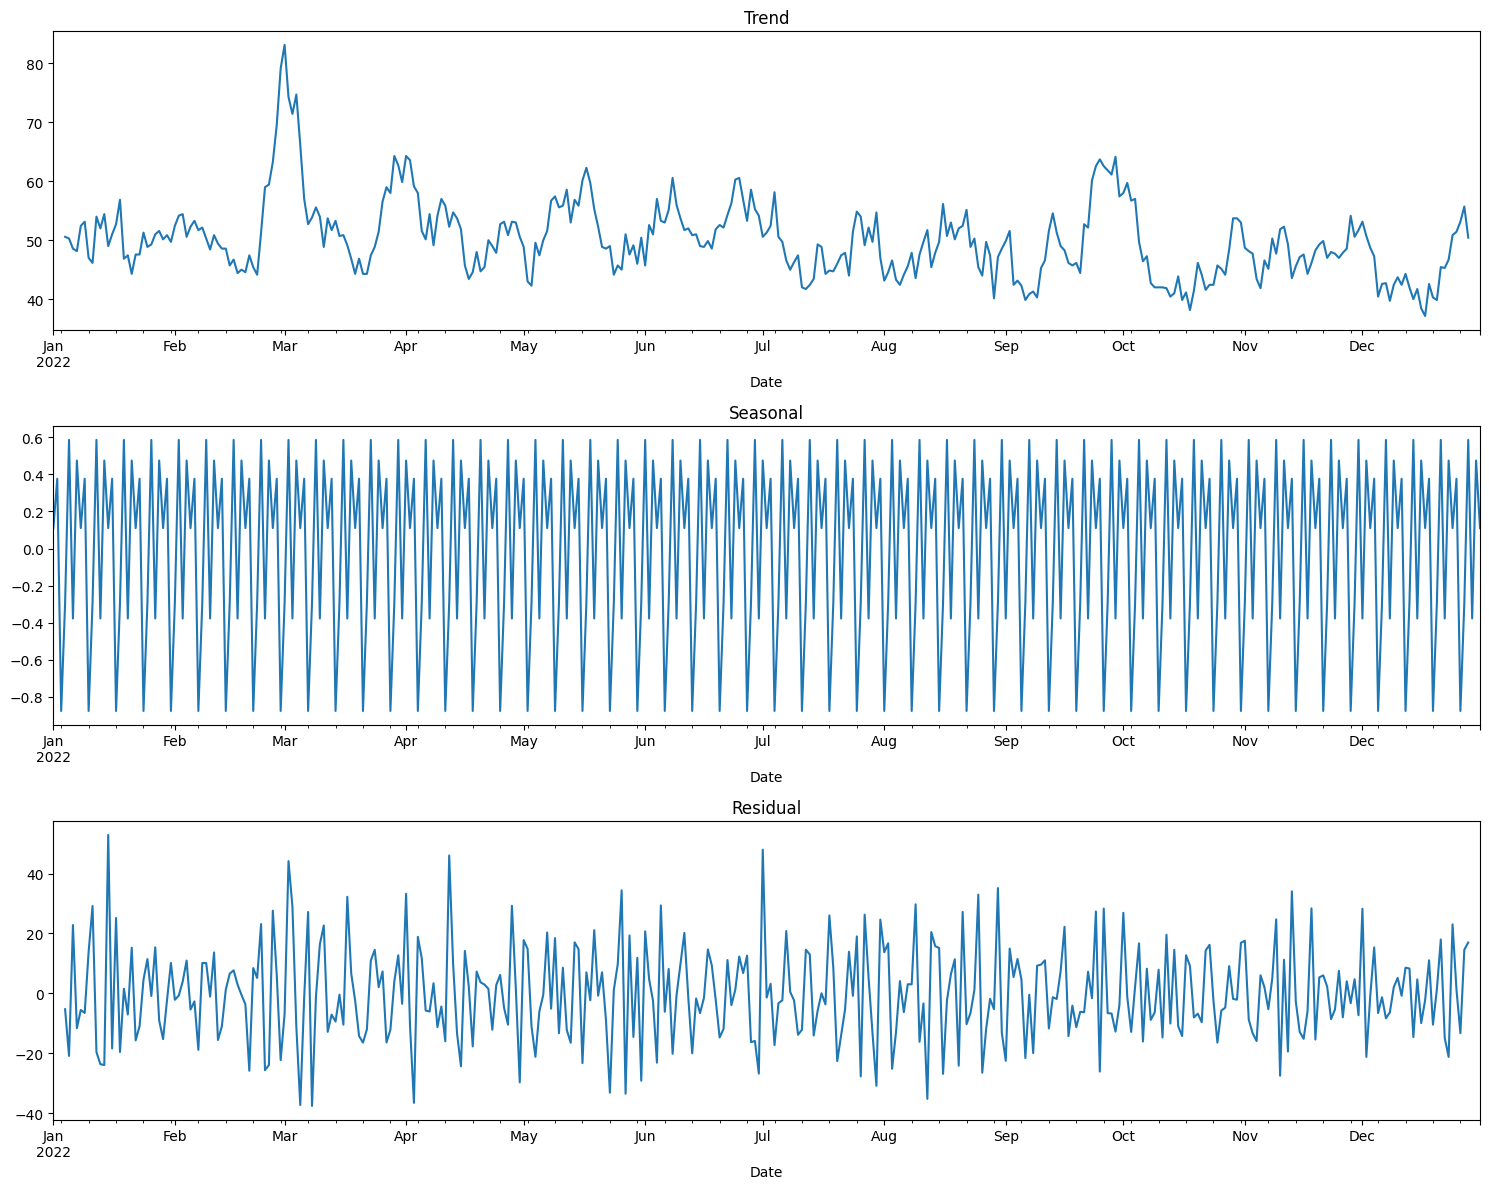

In [ ]:
decompose = seasonal_decompose(df_reg)

fig,ax = plt.subplots(3,1,figsize=(15,12))
decompose.trend.plot(ax=ax[0])
ax[0].set_title('Trend')
decompose.seasonal.plot(ax=ax[1])
ax[1].set_title('Seasonal')
decompose.resid.plot(ax=ax[2])
ax[2].set_title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
#Split Data Train & Test
print(df_reg.shape)
test_size = round(df_reg.shape[0] * 0.15)
train=df_reg.iloc[:-1*(test_size)]
test=df_reg.iloc[-1*(test_size):]
print(train.shape,test.shape)

(365, 1)
(310, 1) (55, 1)


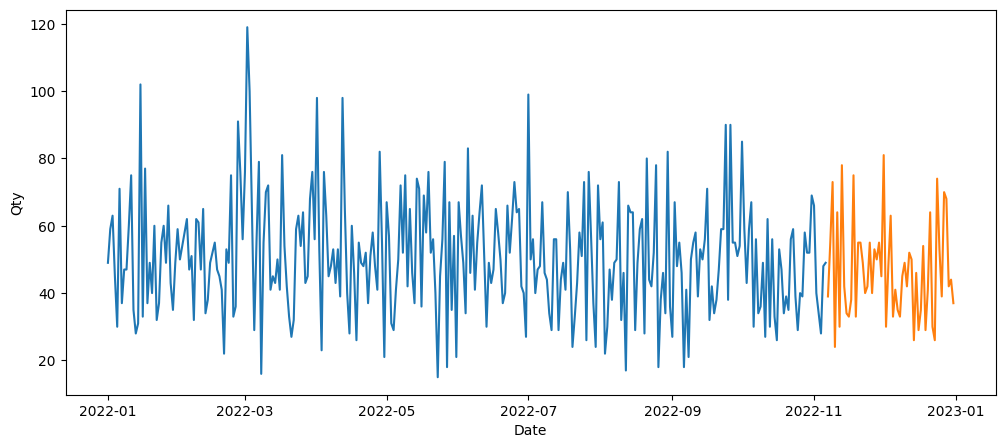

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(data=train, x=train.index, y=train['Qty'])
sns.lineplot(data=test, x=test.index, y=test['Qty'])
plt.show()

In [ ]:
#Data Stationary
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df_reg)

1. ADF :  -19.448086319449082
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


In [ ]:
#auto-fit ARIMA
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
from itertools import product
# Make a list for p, d, and q
p = range(0, 4)
d = range(0, 4)
q = range(0, 4)
# Use the product function from itertools to create a combination of p, d, and q
pdq = list(product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 3, 0), (3, 3, 1), (3, 3, 2), (3, 3, 3)]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Initialize list to store AIC values
aic_scores = []

# Perform a manual grid search to find the optimal p, d, q parameters
for parameters in pdq:
    # Make ARIMA Model
    model = ARIMA(df_reg, order=parameters)
    model_fit = model.fit()
    # Stores AIC values ​​in a list
    aic_scores.append({'param': parameters, 'aic': model_fit.aic})

# Select the parameter with the lowest AIC
best_aic = min(aic_scores, key=lambda x: x['aic'])
print("Best parameters based on AIC:", best_aic)

Best parameters based on AIC: {'param': (2, 1, 3), 'aic': 3087.8267552844973}


In [ ]:
#Hyperparameter tuning
model_hyper = ARIMA(train, order=best_aic['param'])
model_fit_hyper = model_hyper.fit()

In [ ]:
#Trial and error tuning
model_manual = ARIMA(train, order=(40,2,2))
model_fit_manual = model_manual.fit()

<Figure size 5000x100 with 0 Axes>

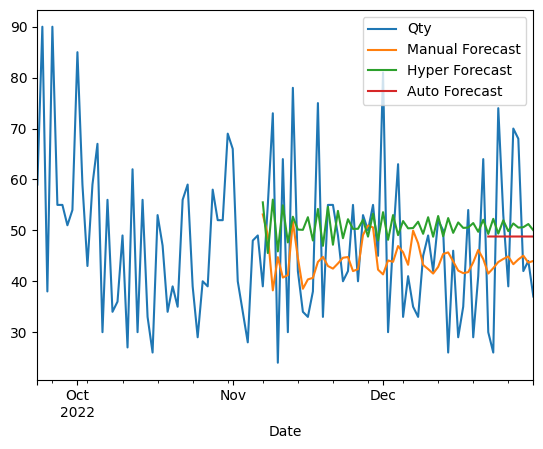

In [ ]:
import matplotlib.pyplot as plt

manual_forecast = model_fit_manual.forecast(steps=len(test))
hyper_forecast = model_fit_hyper.forecast(steps=len(test))
auto_forecast = auto_arima.predict(steps=len(test))

plot_data = df_reg.iloc[-100:]

plot_data['Manual Forecast'] = [None] * (len(plot_data) - len(manual_forecast)) + list(manual_forecast)
plot_data['Hyper Forecast'] = [None] * (len(plot_data) - len(hyper_forecast)) + list(hyper_forecast)
plot_data['Auto Forecast'] = [None] * (len(plot_data) - len(auto_forecast)) + list(auto_forecast)

plt.figure(figsize=(50, 1))

plot_data.plot()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

manual_mae = mean_absolute_error(test, manual_forecast)
manual_mape = mean_absolute_percentage_error(test, manual_forecast)
manual_rmse = np.sqrt(mean_squared_error(test, manual_forecast))

print(f'MAE (Manual Forecast): {round(manual_mae, 4)}')
print(f'MAPE (Manual Forecast): {round(manual_mape, 4)}')
print(f'RMSE (Manual Forecast): {round(manual_rmse, 4)}')

MAE (Manual Forecast): 11.4361
MAPE (Manual Forecast): 0.2514
RMSE (Manual Forecast): 14.7428


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

hyper_mae = mean_absolute_error(test, hyper_forecast)
hyper_mape = mean_absolute_percentage_error(test, hyper_forecast)
hyper_rmse = np.sqrt(mean_squared_error(test, hyper_forecast))

print(f'MAE (Auto ARIMA): {round(hyper_mae, 4)}')
print(f'MAPE (Auto ARIMA): {round(hyper_mape, 4)}')
print(f'RMSE (Auto ARIMA): {round(hyper_rmse, 4)}')

MAE (Auto ARIMA): 12.0733
MAPE (Auto ARIMA): 0.3041
RMSE (Auto ARIMA): 14.3591


In [ ]:
#Apply model to forecast data
model = ARIMA(df_reg, order=(40, 2, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)

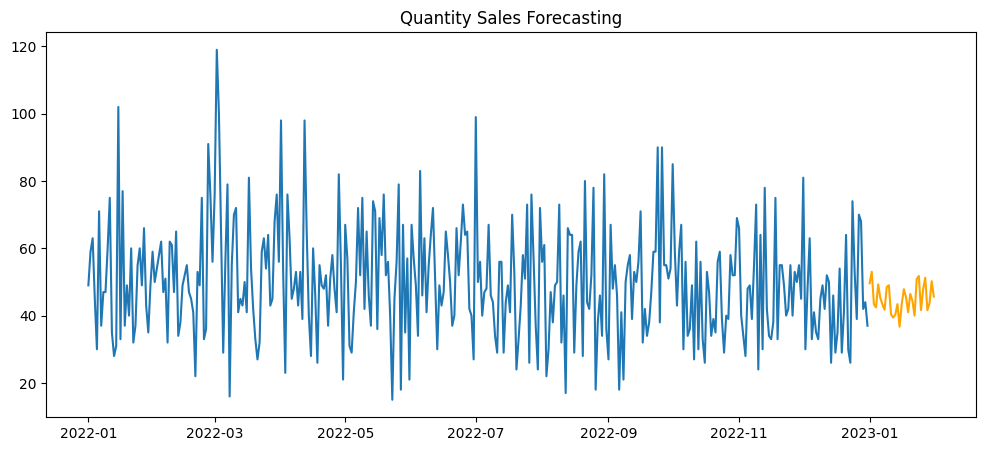

In [ ]:
#Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df_reg)
plt.plot(forecast,color='orange')
plt.title('Quantity Sales Forecasting')
plt.show()

In [ ]:
forecast.describe()

count    31.000000
mean     45.136200
std       4.225419
min      36.717236
25%      41.698971
50%      44.399091
75%      48.762850
max      53.036241
Name: predicted_mean, dtype: float64

###CLUSTERING

In [ ]:
# Creating new dataframe
df_cluster = df_merge.groupby(['CustomerID']).agg({'TransactionID':'count',
                                          'Qty':'sum',
                                          'TotalAmount':'sum'}).reset_index()

In [ ]:
# Normalizing data
from sklearn.preprocessing import MinMaxScaler
new_data = MinMaxScaler().fit_transform(df_cluster)
df_nor = pd.DataFrame(new_data, columns=df_cluster.columns)
df_nor.describe()

,CustomerID,TransactionID,Qty,TotalAmount
count,447.000000,447.000000,447.000000,447.000000
mean,0.500000,0.457246,0.448270,0.358352
std,0.289646,0.180295,0.184879,0.165166
min,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.333333,0.318841,0.238073
50%,0.500000,0.444444,0.434783,0.347336
75%,0.750000,0.611111,0.579710,0.462629
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_nor = df_nor.drop(columns=['CustomerID'])
df_nor.columns

Index(['TransactionID', 'Qty', 'TotalAmount'], dtype='object')

In [ ]:
# Aggregate data
agg = {
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}
cluster_df = df_merge.groupby('CustomerID').aggregate(agg).reset_index()
cluster_df.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [ ]:
# scale data into same range
scaler = StandardScaler()
scaled_df = scaler.fit_transform(cluster_df[['TransactionID', 'Qty', 'TotalAmount']])
scaled_df = pd.DataFrame(scaled_df, columns=['TransactionID', 'Qty', 'TotalAmount'])
scaled_df.head()

,TransactionID,Qty,TotalAmount
0,1.779816,1.496527,2.094768
1,0.545884,1.261093,0.239269
2,1.162850,1.182615,0.672218
3,-0.379565,0.397833,-0.482047
4,-1.305014,-1.093251,-0.754347


In [ ]:
# finding optimal number of clusters
inertia = []
max_clusters = 11
for n_cluster in range(1, max_clusters):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=n_cluster)
    kmeans.fit(cluster_df.drop('CustomerID', axis=1))
    inertia.append(kmeans.inertia_)

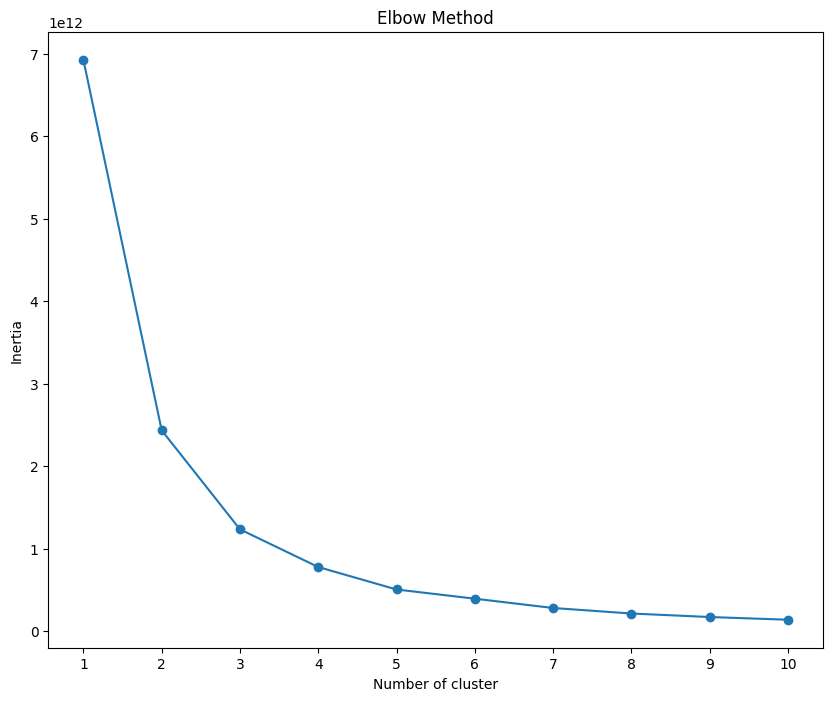

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1, max_clusters), inertia, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.xticks(np.arange(1, max_clusters))
plt.show()

In [ ]:
K = range(2,8)
fits=[]
score=[]

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(df_nor)
    fits.append(model)
    score.append(silhouette_score(df_nor, model.labels_, metric='euclidean'))

<Axes: >

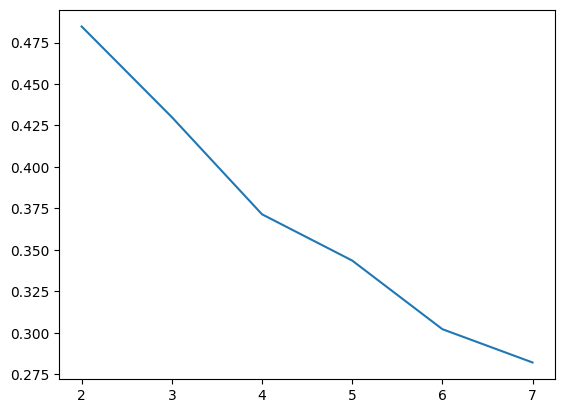

In [ ]:
sns.lineplot(x = K, y = score)

In [ ]:
fits[2]

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [ ]:
cluster_df['cluster']= fits[2].labels_
cluster_df

,CustomerID,TransactionID,Qty,TotalAmount,cluster
0,1,17,60,623300,1
1,2,13,57,392300,2
2,3,15,56,446200,2
3,4,10,46,302500,0
4,5,7,27,268600,3
...,...,...,...,...,...
442,443,16,59,485100,1
443,444,18,62,577700,1
444,445,18,68,587200,1
445,446,11,42,423300,2


In [ ]:
cluster_df.groupby(['cluster']).agg({
    'CustomerID' : 'count',
    'TransactionID': 'mean',
    'Qty':'mean',
    'TotalAmount':'mean'
})

,CustomerID,TransactionID,Qty,TotalAmount
cluster,,,,
0,167,10.251497,36.700599,320391.616766
1,67,16.104478,61.164179,563398.507463
2,123,13.032520,47.804878,424216.260163
3,90,6.955556,24.322222,206792.222222
